## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

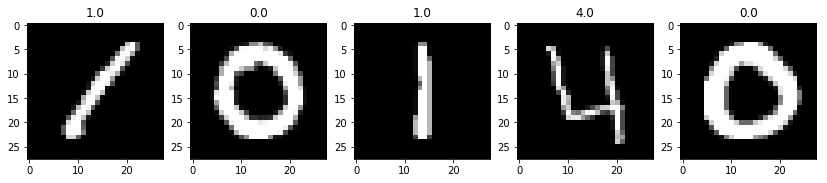

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [8]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [9]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [10]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

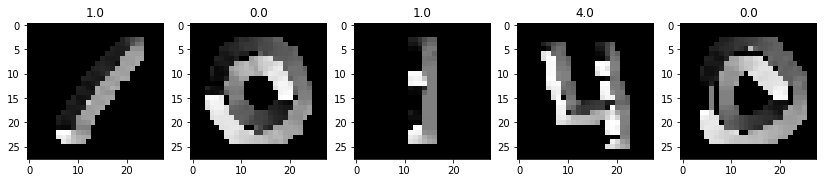

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_theta[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [12]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

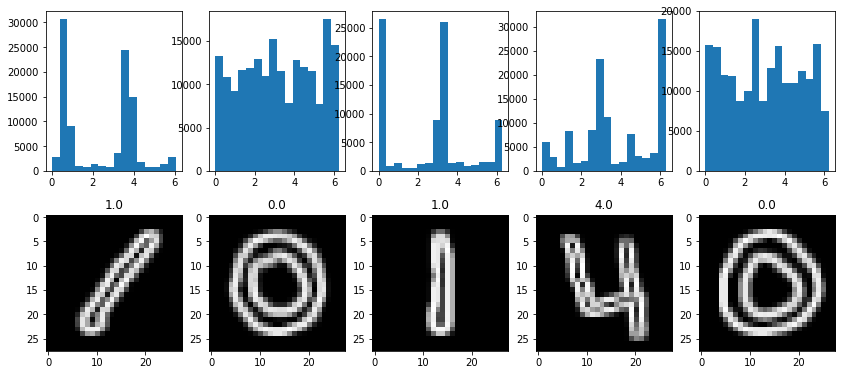

In [13]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5,], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i-1].flatten(),
             bins=16, weights=train_g[i-1].flatten())

In [14]:
# изобажение квадратное 28 х 28, задаем кол-во пикселей для разбиения
n = train_img.shape[1]//2
n

14

## Вычисляем гистограммы градиентов

In [15]:
# Гистограммы вычисляются с учетом длины вектора градиента 
bin_n = 16
train_theta_cells = train_theta[:,:n,:n], train_theta[:,n:,:n], train_theta[:,:n,n:], train_theta[:,n:,n:]
train_g_cells = train_g[:,:n,:n], train_g[:,n:,:n], train_g[:,:n,n:], train_g[:,n:,n:]

test_theta_cells = test_theta[:,:n,:n], test_theta[:,n:,:n], test_theta[:,:n,n:], test_theta[:,n:,n:]
test_g_cells = test_g[:,:n,:n], test_g[:,n:,:n], test_g[:,:n,n:], test_g[:,n:,n:]


In [16]:
hists = np.zeros((len(train_g_cells), len(train_img), bin_n))

for j in range(len(train_g_cells)):
    for i in range(len(train_img)):
        hist, border = np.histogram(train_theta_cells[j][i],
                                 bins=bin_n,
                                 range=(0., 2. * np.pi),
                                 weights=train_g_cells[j][i])
        hists[j,i] = hist
train_hist = np.hstack(hists)  
train_hist.shape

(42000, 64)

In [19]:
hists = np.zeros((len(test_g_cells), len(test_img), bin_n))

for j in range(len(test_g_cells)):
    for i in range(len(test_img)):
        hist, border = np.histogram(test_theta_cells[j][i],
                                 bins=bin_n,
                                 range=(0., 2. * np.pi),
                                 weights=test_g_cells[j][i])
        hists[j,i] = hist
test_hist = np.hstack(hists)  
test_hist.shape

(28000, 64)

## Нормируем вектор гистограммы

In [20]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [21]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [22]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## SVM

In [37]:
from sklearn.svm import SVC
#clf = SVC(kernel='linear', C=1, gamma=1) 
clf = SVC(kernel='rbf', C=1, gamma=1) 
clf.fit(x_train, y_train)
pred_val = clf.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [38]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9698809523809524


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98       816
        1.0       0.99      0.99      0.99       909
        2.0       0.97      0.97      0.97       846
        3.0       0.96      0.96      0.96       937
        4.0       0.98      0.96      0.97       839
        5.0       0.97      0.96      0.96       702
        6.0       0.96      0.98      0.97       785
        7.0       0.97      0.97      0.97       893
        8.0       0.95      0.96      0.96       835
        9.0       0.96      0.96      0.96       838

avg / total       0.97      0.97      0.97      8400



In [40]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[807   0   2   1   2   2   2   0   0   0]
 [  0 900   3   0   2   0   3   1   0   0]
 [  4   1 821   7   2   0   2   2   7   0]
 [  0   0  12 895   0  11   0   6  10   3]
 [  2   2   0   0 807   0  11   3   2  12]
 [  1   0   0  14   1 673   4   1   8   0]
 [  2   3   0   0   1   4 772   0   3   0]
 [  0   1   5   3   2   0   0 870   3   9]
 [  4   2   2   5   2   3   9   2 800   6]
 [  4   2   1   4   4   4   0  10   7 802]]


## Предсказания на тестовых данных

In [41]:
pred_test = clf.predict(test_hist)

## Визуализируем предсказания

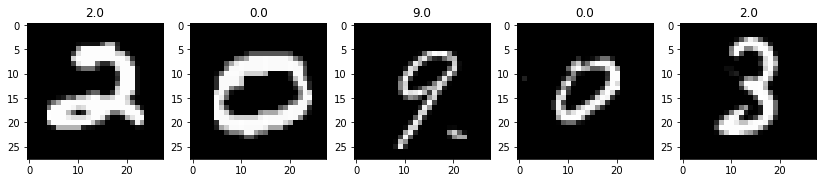

In [42]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [43]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, np.int(p)))

In [44]:
# Your submission scored 0.96900 для 'rbf', 0.94814 для 'linear'